## Постановка задачи
По 1260 опрошенным имеются следующие данные:

* заработная плата за час работы, $;
* опыт работы, лет;
* образование, лет;
* внешняя привлекательность, в баллах от 1 до 5;
* бинарные признаки: пол, семейное положение, состояние здоровья (хорошее/плохое), членство в профсоюзе, цвет кожи (белый/чёрный), занятость в сфере обслуживания (да/нет).

Требуется оценить влияние внешней привлекательности на уровень заработка с учётом всех остальных факторов.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import numpy as np
import pandas as pd
import statsmodels.api as sm

In [2]:
df = pd.read_csv('beauty.csv', sep=';')
df.head()

,wage,exper,union,goodhlth,black,female,married,service,educ,looks
0,5.73,30,0,1,0,1,1,1,14,4
1,4.28,28,0,1,0,1,1,0,12,3
2,7.96,35,0,1,0,1,0,0,10,4
3,11.57,38,0,1,0,0,1,1,16,3
4,11.42,27,0,1,0,0,1,0,16,3


### Визуальный анализ и предобработка
Посмотрим на распределение оценок привлекательности:

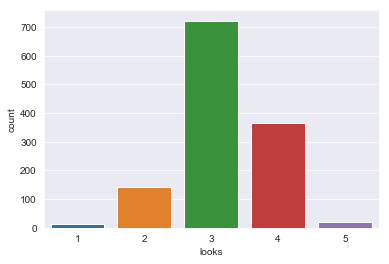

In [3]:
sns.countplot(df.looks)

В группах looks=1 и looks=5 слишком мало наблюдений. Превратим признак looks в категориальный и закодируем с помощью фиктивных переменных:

In [7]:
df = df.assign(looks_above_avg=(df.looks > 3).astype(int))
df = df.assign(looks_below_avg=(df.looks < 3).astype(int))
df = df.drop('looks', axis=1)

Распределение значений отклика:

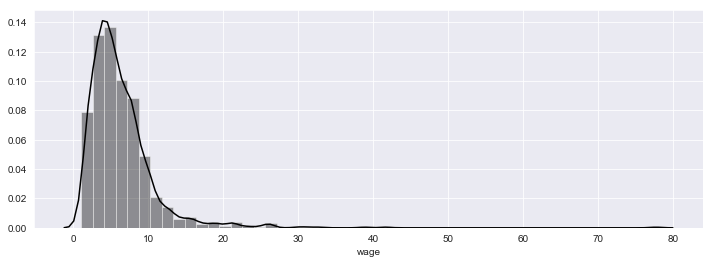

In [10]:
plt.figure(figsize=(12, 4))
sns.distplot(df['wage'], color='black')

In [6]:
df['wage'].sort_values(ascending=False).head(n=10)

602     77.72
269     41.67
415     38.86
69      32.79
290     31.09
68      29.98
1113    26.24
1108    26.24
299     26.24
396     26.22
Name: wage, dtype: float64

**Один человек в выборке получает `77.72$` в час, остальные — меньше `45$`; удалим этого человека.**

In [7]:
df = df.drop(602, axis=0)

In [8]:
df['wage'].max() / df['wage'].min()

40.85294117647059

$\frac{\mathrm{max}y}{\mathrm{min}y} = 40.85 > 10$, поэтому найдём преобразование отклика методом Бокса-Кокса:

In [12]:
from scipy.stats import boxcox
alpha = 0.05 # Уровень значимости
_, lambda_max, lambda_ci = boxcox(df.wage, alpha=alpha)
print('Optimal lambda for Box-Cox tranformation: lambda={:.2f}. {:.0%}-confidence interval: [{:.2f}, {:.2f}]'.format(
    lambda_max, 1.0 - alpha, *lambda_ci
))

Optimal lambda for Box-Cox tranformation: lambda=-0.04. 95%-confidence interval: [-0.11, 0.03]


0 принадлежит доверительному интервалу Бокса-Кокса. Для интерпретируемости результатов будем использовать $\lambda=0$, что соответствует логарифмированию зарплат

In [13]:
df = df.assign(logwage=np.log(df['wage']))
df = df.drop('wage', axis=1)

## Построение и анализ моделей

### Модель 1: Линейная модель со всеми признаками

In [15]:
import statsmodels.api as sm

In [16]:
X = df.drop('logwage', axis=1)
X = sm.add_constant(X)
y = df['logwage']
model1 = sm.OLS(y, X).fit()

/Users/khalman/miniconda2/envs/python3.6/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


#### Остатки модели
Проверим остатки модели на нормальность, несмещённость и гомоскедастичность

In [17]:
from scipy.stats import shapiro, wilcoxon
from statsmodels.stats.diagnostic import het_breuschpagan

def residuals_diagnosis(model):
    print('Shapiro pval: {}'.format(shapiro(model.resid)[1]))
    print('Wilcoxon pval: {}'.format(wilcoxon(model.resid)[1]))
    print('Breusch-Pagan pval: {}'.format(
        het_breuschpagan(model.resid, pd.DataFrame(model.model.exog, columns=model.model.exog_names))[1]))
    
residuals_diagnosis(model1)

Shapiro pval: 4.1274424850135105e-11
Wilcoxon pval: 0.8383198641147629
Breusch-Pagan pval: 0.0027022592001078624


ненормальны, поэтому для проверки несмещённости используем критерий знаковых рангов Уилкоксона.  
Остатки гетероскедастичны, поэтому нужно использовать устойчивые оценки дисперсии Уайта

In [22]:
model1.get_robustcov_results().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                logwage   R-squared:                       0.373
Model:                            OLS   Adj. R-squared:                  0.368
Method:                 Least Squares   F-statistic:                     86.34
Date:                Thu, 12 Dec 2019   Prob (F-statistic):          5.55e-135
Time:                        21:05:16   Log-Likelihood:                -838.47
No. Observations:                1260   AIC:                             1699.
Df Residuals:                    1249   BIC:                             1755.
Df Model:                          10                                         
Covariance Type:                  HC1                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.4345      0.107      4.066      0.000       0.225       0.644
exper               0.0136      0.001     10.805      0.000       0.011       0.016
union               0.1890      0.029      6.535      0.000       0.132       0.246
goodhlth            0.0805      0.063      1.279      0.201      -0.043       0.204
black              -0.0650      0.061     -1.060      0.289      -0.185       0.055
female             -0.3882      0.032    -12.125      0.000      -0.451      -0.325
married             0.0522      0.032      1.647      0.100      -0.010       0.114
service            -0.1425      0.035     -4.107      0.000      -0.211      -0.074
educ                0.0801      0.006     14.098      0.000       0.069       0.091
looks_above_avg     0.0044      0.031      0.140      0.889      -0.057       0.066
looks_below_avg    -0.1290      0.040     -3.219      0.001      -0.208      -0.050
==============================================================================
Omnibus:                       86.697   Durbin-Watson:                   1.861
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              237.076
Skew:                           0.351   Prob(JB):                     3.31e-52
Kurtosis:                       5.006   Cond. No.                         189.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

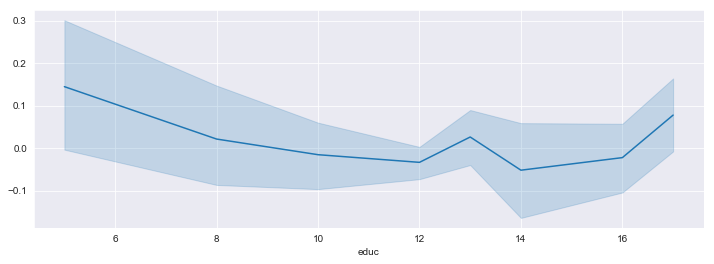

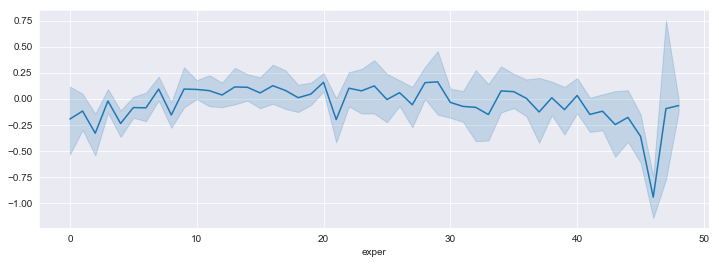

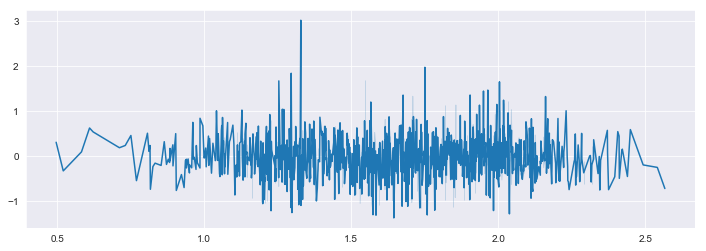

In [25]:
for col_name in ['educ', 'exper']:
    plt.figure(figsize=(12, 4))
    sns.lineplot(X[col_name], model1.resid)
    
plt.figure(figsize=(12, 4))
sns.lineplot(model1.fittedvalues, model1.resid)

В остатках наблюдается квадратичная зависимость от опыта работы.

### Модель 2

In [31]:
formula = 'logwage ~ exper + I(exper ** 2) + educ  + union + goodhlth + black + female + married + service '\
          '+ looks_above_avg + looks_below_avg'
model2 = sm.OLS.from_formula(formula, data=df).fit()
residuals_diagnosis(model2)
model2.get_robustcov_results().summary()

Shapiro pval: 7.647839826707692e-12
Wilcoxon pval: 0.8457671203308172
Breusch-Pagan pval: 0.00040985674293103695


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                logwage   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.386
Method:                 Least Squares   F-statistic:                     85.60
Date:                Thu, 12 Dec 2019   Prob (F-statistic):          7.41e-144
Time:                        21:12:45   Log-Likelihood:                -819.26
No. Observations:                1260   AIC:                             1663.
Df Residuals:                    1248   BIC:                             1724.
Df Model:                          11                                         
Covariance Type:                  HC1                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.3257      0.105      3.090      0.002       0.119       0.533
exper               0.0401      0.004      9.422      0.000       0.032       0.048
I(exper ** 2)      -0.0006   9.46e-05     -6.438      0.000      -0.001      -0.000
educ                0.0759      0.006     13.382      0.000       0.065       0.087
union               0.1816      0.028      6.395      0.000       0.126       0.237
goodhlth            0.0737      0.064      1.159      0.247      -0.051       0.198
black              -0.0492      0.062     -0.799      0.424      -0.170       0.072
female             -0.3879      0.031    -12.334      0.000      -0.450      -0.326
married             0.0200      0.031      0.641      0.522      -0.041       0.081
service            -0.1518      0.034     -4.428      0.000      -0.219      -0.085
looks_above_avg     0.0061      0.031      0.196      0.844      -0.055       0.067
looks_below_avg    -0.1337      0.040     -3.342      0.001      -0.212      -0.055
==============================================================================
Omnibus:                       92.557   Durbin-Watson:                   1.860
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              280.583
Skew:                           0.344   Prob(JB):                     1.18e-61
Kurtosis:                       5.207   Cond. No.                     5.61e+03
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 5.61e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Незначимые признаки: здоровье, цвет кожи, семейное положение, привлекательность выше среднего. Прежде, чем удалять лишние признаки, проверим, не входят ли они в значимые попарные взаимодействия:**

In [32]:
formula = 'logwage ~ exper + educ + I(exper ** 2) + union + goodhlth + black + female + married + service' \
          '+ looks_above_avg + looks_below_avg' \
          '+ black:educ + black:exper + black:I(exper^2) + black:union + black:female + black:married + black:service' \
          '+ black:looks_above_avg + black:looks_below_avg'
model = sm.OLS.from_formula(formula, data=df).fit()
print(model.get_robustcov_results().summary())

                            OLS Regression Results                            
Dep. Variable:                logwage   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                     51.21
Date:                Thu, 12 Dec 2019   Prob (F-statistic):          2.58e-146
Time:                        21:16:08   Log-Likelihood:                -806.19
No. Observations:                1260   AIC:                             1654.
Df Residuals:                    1239   BIC:                             1762.
Df Model:                          20                                         
Covariance Type:                  HC1                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.33

In [33]:
formula = 'logwage ~ exper + educ + I(exper ** 2) + union + goodhlth + black + female + married + service' \
          '+ looks_above_avg + looks_below_avg' \
          '+ female:educ + female:exper + female:I(exper ** 2) + female:union + female:female' \
          '+ female:married + female:service + female:looks_above_avg + female:looks_below_avg'
model = sm.OLS.from_formula(formula, data=df).fit()
print(model.get_robustcov_results().summary())

                            OLS Regression Results                            
Dep. Variable:                logwage   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     53.61
Date:                Thu, 12 Dec 2019   Prob (F-statistic):          2.01e-146
Time:                        21:16:08   Log-Likelihood:                -802.82
No. Observations:                1260   AIC:                             1646.
Df Residuals:                    1240   BIC:                             1748.
Df Model:                          19                                         
Covariance Type:                  HC1                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0

In [34]:
formula = 'logwage ~ exper + educ + I(exper ** 2) + union + goodhlth + black + female + married + service' \
          '+ looks_above_avg + looks_below_avg' \
          '+ goodhlth:educ + goodhlth:I(exper  ** 2) + goodhlth:exper + goodhlth:union + goodhlth:goodhlth' \
          '+ goodhlth:married + goodhlth:service + goodhlth:looks_above_avg + goodhlth:looks_below_avg'
model = sm.OLS.from_formula(formula, data=df).fit()
print(model.get_robustcov_results().summary())

                            OLS Regression Results                            
Dep. Variable:                logwage   R-squared:                       0.398
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     53.43
Date:                Thu, 12 Dec 2019   Prob (F-statistic):          5.08e-146
Time:                        21:16:25   Log-Likelihood:                -812.27
No. Observations:                1260   AIC:                             1665.
Df Residuals:                    1240   BIC:                             1767.
Df Model:                          19                                         
Covariance Type:                  HC1                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

### Модель 3

Удалим из модели 2 незначимые признаки и добавим межфакторное взаимодействие пола и опыта работы.

In [36]:
formula = 'logwage ~ exper + I(exper ** 2) + educ + union + service ' \
          '+ looks_above_avg + looks_below_avg + exper:female'
model3 = sm.OLS.from_formula(formula, data=df).fit()
residuals_diagnosis(model3)
print(model3.get_robustcov_results().summary())

Shapiro pval: 1.7958683151686472e-11
Wilcoxon pval: 0.8200371816338569
Breusch-Pagan pval: 0.0022407537318617
                            OLS Regression Results                            
Dep. Variable:                logwage   R-squared:                       0.384
Model:                            OLS   Adj. R-squared:                  0.380
Method:                 Least Squares   F-statistic:                     101.6
Date:                Thu, 12 Dec 2019   Prob (F-statistic):          2.67e-130
Time:                        21:17:16   Log-Likelihood:                -826.49
No. Observations:                1260   AIC:                             1671.
Df Residuals:                    1251   BIC:                             1717.
Df Model:                           8                                         
Covariance Type:                  HC1                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
----------------

### Модель 4
Попробуем оставить в модели 2 цвет кожи и семейное положение, чтобы добавить их взаимодействия с полом. Как и в модели 3, добавим взаимодействие пола с опытом работы, а состояние здоровья и квадрат опыта удалим.

In [50]:
formula = 'logwage ~ exper + I(exper ** 2) + '\
        'married + female * black + female * married + '\
        'union + service + educ + looks_above_avg + looks_below_avg'
model4 = sm.OLS.from_formula(formula, data=df).fit()
print(model4.get_robustcov_results().summary())
residuals_diagnosis(model4)

                            OLS Regression Results                            
Dep. Variable:                logwage   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     82.52
Date:                Thu, 12 Dec 2019   Prob (F-statistic):          1.13e-139
Time:                        21:24:22   Log-Likelihood:                -826.33
No. Observations:                1260   AIC:                             1677.
Df Residuals:                    1248   BIC:                             1738.
Df Model:                          11                                         
Covariance Type:                  HC1                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.4733      0.089     

## Расстояние Кука

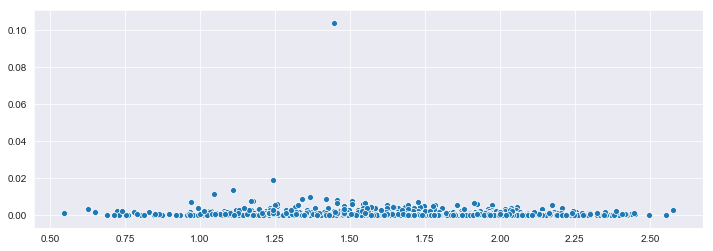

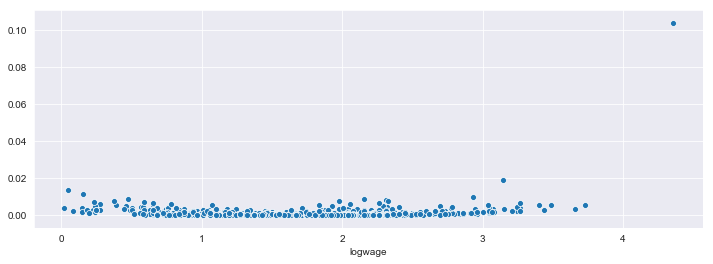

In [51]:
infl = model4.get_influence()
plt.figure(figsize=(12, 4))
sns.scatterplot(model4.fittedvalues, infl.cooks_distance[0])
plt.figure(figsize=(12, 4))
sns.scatterplot(df.logwage, infl.cooks_distance[0])

Попробуем удалить наблюдения с расстоянием Кука больше 0.015:

In [47]:
formula = 'logwage ~ exper + I(exper ** 2) + '\
        'married + female * black + female * married + '\
        'union + service + educ + looks_above_avg + looks_below_avg'
new_df = df[infl.cooks_distance[0] < 0.08]
model5 = sm.OLS.from_formula(formula, data=new_df).fit()
print(model5.get_robustcov_results().summary())
residuals_diagnosis(model5)

                            OLS Regression Results                            
Dep. Variable:                logwage   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.407
Method:                 Least Squares   F-statistic:                     84.38
Date:                Thu, 12 Dec 2019   Prob (F-statistic):          1.70e-151
Time:                        21:23:28   Log-Likelihood:                -786.57
No. Observations:                1259   AIC:                             1599.
Df Residuals:                    1246   BIC:                             1666.
Df Model:                          12                                         
Covariance Type:                  HC1                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.3702      0.087     

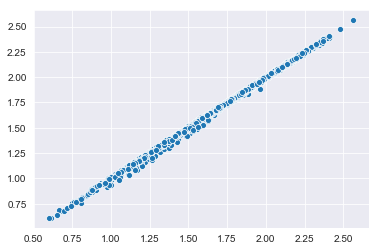

In [48]:
sns.scatterplot(model4.fittedvalues, model5.fittedvalues)

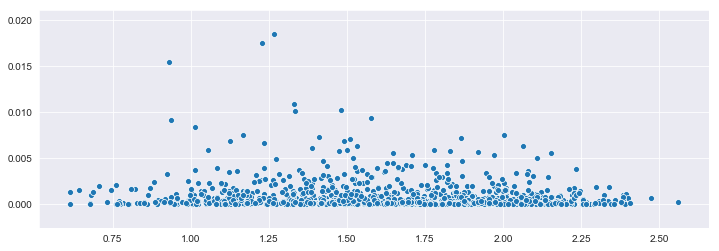

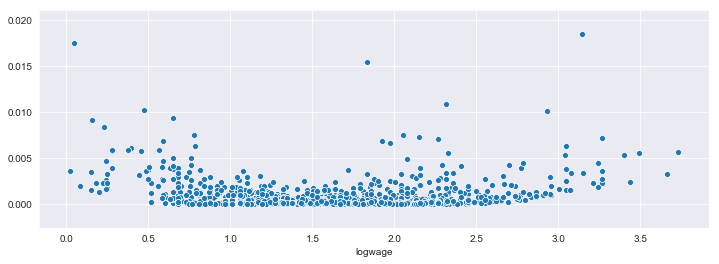

In [49]:
infl = model5.get_influence()
plt.figure(figsize=(12, 4))
sns.scatterplot(model5.fittedvalues, infl.cooks_distance[0])
plt.figure(figsize=(12, 4))
sns.scatterplot(new_df.logwage, infl.cooks_distance[0])

In [52]:
formula = 'logwage ~ exper + I(exper ** 2) + '\
        'married + female * black + female * married + '\
        'union + service + educ + looks_above_avg + looks_below_avg'
new_df = df[infl.cooks_distance[0] < 0.015]
model6 = sm.OLS.from_formula(formula, data=new_df).fit()
print(model6.get_robustcov_results().summary())
residuals_diagnosis(model6)

                            OLS Regression Results                            
Dep. Variable:                logwage   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                     86.43
Date:                Thu, 12 Dec 2019   Prob (F-statistic):          2.30e-154
Time:                        21:25:21   Log-Likelihood:                -777.66
No. Observations:                1258   AIC:                             1581.
Df Residuals:                    1245   BIC:                             1648.
Df Model:                          12                                         
Covariance Type:                  HC1                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.3409      0.083     

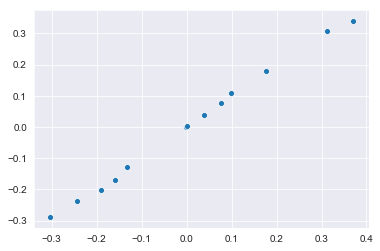

In [55]:
sns.scatterplot(model5.params, model6.params)

Видим, что модель, построенная на выборке без выбросов не отличаются от оригинальной модели

## Результаты и выводы

Итоговая модель (№4) построена по 1255 из 1260 исходных объектов и объясняет 41.2% вариации логарифма отклика:

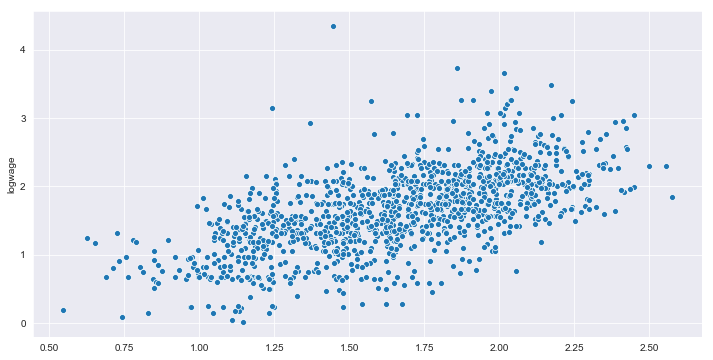

In [57]:
plt.figure(figsize=(12, 6))
sns.scatterplot(model4.fittedvalues, df.logwage)

Все признаки статистически значимы

In [58]:
model4.get_robustcov_results().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                logwage   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     82.52
Date:                Thu, 12 Dec 2019   Prob (F-statistic):          1.13e-139
Time:                        21:27:36   Log-Likelihood:                -826.33
No. Observations:                1260   AIC:                             1677.
Df Residuals:                    1248   BIC:                             1738.
Df Model:                          11                                         
Covariance Type:                  HC1                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.4733      0.089      5.340      0.000       0.299       0.647
exper               0.0129      0.001     10.539      0.000       0.010       0.015
married             0.1352      0.042      3.208      0.001       0.053       0.218
female             -0.3099      0.050     -6.152      0.000      -0.409      -0.211
black              -0.2692      0.074     -3.624      0.000      -0.415      -0.123
female:black        0.3932      0.116      3.402      0.001       0.166       0.620
female:married     -0.1862      0.061     -3.067      0.002      -0.305      -0.067
union               0.1942      0.029      6.749      0.000       0.138       0.251
service            -0.1428      0.035     -4.117      0.000      -0.211      -0.075
educ                0.0795      0.006     14.172      0.000       0.069       0.091
looks_above_avg     0.0092      0.031      0.295      0.768      -0.052       0.070
looks_below_avg    -0.1264      0.040     -3.196      0.001      -0.204      -0.049
==============================================================================
Omnibus:                       75.657   Durbin-Watson:                   1.843
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              186.705
Skew:                           0.330   Prob(JB):                     2.87e-41
Kurtosis:                       4.766   Cond. No.                         225.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

При интересующих нас факторах привлекательности стоят следующие коэффициенты:

In [59]:
table =  model4.get_robustcov_results().summary().tables[1]
pd.DataFrame(table, columns=table.data[0])[-2:]

,,coef,std err,t,P>|t|,[0.025,0.975]
11,looks_above_avg,0.0092,0.031,0.295,0.768,-0.052,0.070
12,looks_below_avg,-0.1264,0.040,-3.196,0.001,-0.204,-0.049


Посчитаем доверительный интервал на ожидаемое изменение средней зарплаты относительно среднего значения при учёте дополнительных факторов:

In [60]:
print('Looks below average: {:.2%} [{:.2%}, {:.2%}]'.format(
    np.exp(-0.1264) - 1, np.exp(-0.204) - 1, np.exp(-0.049) - 1))
print('Looks above average: {:.2%} [{:.2%}, {:.2%}]'.format(
    np.exp(0.0092) - 1, np.exp(-0.052) - 1, np.exp(0.070) - 1))

Looks below average: -11.87% [-18.45%, -4.78%]
Looks above average: 0.92% [-5.07%, 7.25%]


Таким образом, с учётом дополнительных факторов представители генеральной совокупности, из которой взята выборка, получают на 12% меньше (доверительный интервал [-18.45%, -4.78%], p=0.001), если их привлекательность ниже средней.   
Для пользователей с уровнем привлекательности выше средней, средняя зарплата соответствует средней зарплате по популяции с учётом остальных факторов (доверительный интервал на относительное изменение зарплат: [-5.73%, 6.08%])